# Project 3

Max Schrader

10/14/2021

1. Design an RSLQR to track a constant airspeed command and a constant angle-of-attack
command;
2. Design an RSLQR to track a constant roll angle command;
3. Simulate the linear airplane dynamics with the decoupled control systems with a step response
on the command

In [1]:
from typing import *

import numpy as np
from scipy.integrate import solve_ivp
import scipy.linalg as la
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from control import StateSpace
from control.matlab import lsim, step

pio.templates.default = "ggplot2"
pio.renderers.default = "jupyterlab"

### Creating the LTI State Space Model

In [2]:
class Plane:
    MAX_STEP = 0.1

    def __init__(self, ) -> None:
        self.A = np.array([
            [-0.038, 18.984, 0, -32.174, 0, 0, 0, 0],
            [-0.001, -0.632, 1, 0, 0, 0, 0, 0],
            [0, -0.759, -0.518, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, -0.0829, 0, -1, 0.0487],
            [0, 0, 0, 0, -4.546, -1.699, 0.1717, 0],
            [0, 0, 0, 0, 3.382, -0.0654, -0.0893, 0],
            [0, 0, 0, 0, 0, 1, 0, 0]
        ])

        self.B = np.array([
            [0, 10.1, 0, 0],
            [-0.0086, 0, 0, 0],
            [-0.011, 0.025, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0.0116],
            [0, 0, 27.276, 0.5758],
            [0, 0, 0.3952, -1.362],
            [0, 0, 0, 0],
        ])

        self.x0 = np.array(
            [250, 0, 0, 0, 0, 0, 0, 0]
        )

    def optimal_f(self, time_vector: np.ndarray, target_states: List[np.ndarray], Q: np.ndarray, R: np.ndarray, control_index: tuple) -> object:
        
        A = np.r_[[[0, 1, 0, 0, 0, 0, 0, 0, 0]], np.c_[self.A, np.zeros(self.A.shape[0])]]
        B = np.r_[[[0] * self.B.shape[1]], self.B]
        K = self.design_lrq(A, B, Q, R)
        C = np.diag([0] + [-1 if i in control_index else 0 for i in range(self.A.shape[0])])

        if target_states[0].shape[0] != B.shape[0]:
            target_states = [np.append([0], _t) for _t in target_states]
            
        # creating the target function
        t_div = (time_vector[-1] - time_vector[0]) / len(target_states)
        t_f = lambda t: target_states[int(t // t_div)]
        
        Aaug = A-B@K
        X0 = np.append([0], self.x0)

        def f(t, x_t, ):
            wr = t_f(t)
            return np.array(((Aaug @ (x_t - wr).T) + C @ (wr - X0)))[0]
        
        return f

    @property
    def ss(self, ) -> StateSpace:
        return StateSpace(self.A, self.B, np.eye(self.A.shape[0]), np.zeros(self.B.shape))

    def simulate_uncontrolled(self, t_vect: np.ndarray, u_vect: np.ndarray, ) -> Tuple[np.ndarray]:
        self.T = t_vect
        self.U = u_vect
        return solve_ivp(self._f(), y0=self.x0, t_span=(t_vect[0], t_vect[-1]), max_step=Plane.MAX_STEP, args=(None, ))

    def simulate_controlled(self, time_vector: np.ndarray, *args, **kwargs) -> Tuple[np.ndarray]:
        # this is a bad practive but getting lazy
        augx0 = np.append([0], self.x0,)
        return solve_ivp(self.optimal_f(time_vector, *args, **kwargs), y0=augx0, t_span=(time_vector[0], time_vector[-1]), max_step=Plane.MAX_STEP)

    def _f(self, ):
        def f(t, x_t, wr):
            U = np.array(self.step_function(t))
            return self.A @ (x_t - self.x0) + (self.B @ U.T)
        return f

    def step_function(self, t: float):
        return self.U[int(t // ((self.T[-1] - self.T[0]) / len(self.U)))]

    @staticmethod
    def design_lrq(A, B, Q, R) -> None:
        X = np.matrix(
            la.solve_continuous_are(
                A, B, Q, R, e=None, balanced=True)
        )

        # compute the LQR gain
        K = np.matrix(la.inv(R) @ (B.T@ X))
        
        # find the eigne values
        eigVals, eigVecs = la.eig(A-B*K)

        return K
    
    def control_lqr(self, ) -> np.ndarray:
        # This function is used as a check of my own LQR implementation
        from control import lqr

        return lqr(self.ss, self.Q, self.R)

    @staticmethod
    def plot(t: np.ndarray, y: np.ndarray, u: np.ndarray, flat: bool = True, target: tuple = None, input_: bool = True) -> None:
        fig = make_subplots(rows=5 if input_ else 3,
                            cols=1,
                            shared_xaxes=True,
                            vertical_spacing=0.05,
                            subplot_titles=("Airspeed",
                                            "Angular Velocity",
                                            "Angles",
                                            "Control Surface Deflection",
                                            "Thrust",
                                            )
                            )

        for j, (data, yaxis_title, inner_settings) in enumerate(
            [[y, "ft/s", [["u", 0]]],
             [y, "rad/s", [["q", 2], ["r", 6], ["p", 5]]],
             [y, "rad", [["phi", 7], ["theta", 3], ["beta", 4], ["alpha", 1]]],
             [u, "rad", [["elevator", 0], ["airlerons", 2], ["rudder", 3]]],
             [u, "lbs", [["thrust", 1]]],
             ]
        ):
            if input_ or j < 3: 
                for name, ind in inner_settings:
                    fig.add_trace(go.Scatter(
                        x=t,
                        #                     y=[val[ind] + self.u_bar if j < 1 else val[ind] for val in data],
                        y=data[ind] if flat else [val[ind] for val in data],
                        name=name
                    ),
                        row=j + 1, col=1
                    )

                    if target and j < 3:
                        fig.add_trace(
                            go.Scatter(
                            x=target[0],
                            y=[val[ind] for val in target[1]],
                            line_color="black",
                            line_dash="dash",
                            name="Target",
                            showlegend=j < 1 
                        ),
                        row=j + 1, 
                        col=1,
                    )

                update_dict = {
                    f"yaxis{j+1}" if j > 0 else "yaxis": dict(title=yaxis_title)
                }
            fig.update_layout(update_dict)
        fig.update_layout(
            height=800
        )

        fig.show()

## Simulate the linear airplane dynamics with the decoupled control systems with a step response on the command

In [3]:
p = Plane()

----
$[u, v, w]$ = linear velocity $ft/s$

$[p, q, r]$ = angular velocity $rad/s$

$[\phi, \theta, \psi]$ = Euler angles $rad$

$\alpha$ = angles of attack $rad$

$\beta$ = sideslip angle $rad$

---

$\delta_a$ = control surface deflection airlerons

$\delta_e$ = control surface deflection elevator

$\delta_r$ = control surface deflection rudder

$\delta_t$ = propeller thrust

### Thrust

In [4]:
u = np.array([[0, 0, 0, 0]] * 10 + [[0, 0.1, 0, 0]] * 90)
res = p.simulate_uncontrolled(np.linspace(0, 20, 100), u)
p.plot(res.t, res.y, [[p.step_function(_t)[i] for _t in res.t] for i in range(4)], flat=True)
# res.y

### Elevator

In [5]:
u = np.array([[0, 0, 0, 0]] * 10 + [[0.4, 0, 0, 0]] * 90)
res = p.simulate_uncontrolled(np.linspace(0, 20, 100), u)
p.plot(res.t, res.y, [[p.step_function(_t)[i] for _t in res.t] for i in range(4)], flat=True)

### Airlerons

In [6]:
u = np.array([[0, 0, 0, 0]] * 10 + [[0, 0, 1, 0]] * 90)
res = p.simulate_uncontrolled(np.linspace(0, 20, 100), u)
p.plot(res.t, res.y, [[p.step_function(_t)[i] for _t in res.t] for i in range(4)], flat=True)

### Rudder

In [7]:
u = np.array([[0, 0, 0, 0]] * 10 + [[0, 0, 0, 1]] * 90)
res = p.simulate_uncontrolled(np.linspace(0, 20, 100), u)
p.plot(res.t, res.y, [[p.step_function(_t)[i] for _t in res.t] for i in range(4)], flat=True)

## Design an RSLQR to track a constant airspeed command and a constant angle-of-attack command

In [8]:
target_pos = [np.array([250, 0, 0, 0, 0, 0, 0, 0])] * 20 +  [np.array([251, 0.1, 0, 0, 0, 0, 0, 0])] * 80
time_vect = np.linspace(0, 20, 100)

In [9]:
R = np.diag([1, 1, 1, 1]) * 1
Q = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1]) * 10

In [10]:
p = Plane()

In [11]:
res = p.simulate_controlled(time_vector=time_vect, target_states=target_pos, Q=Q, R=R, control_index=(0, 3))

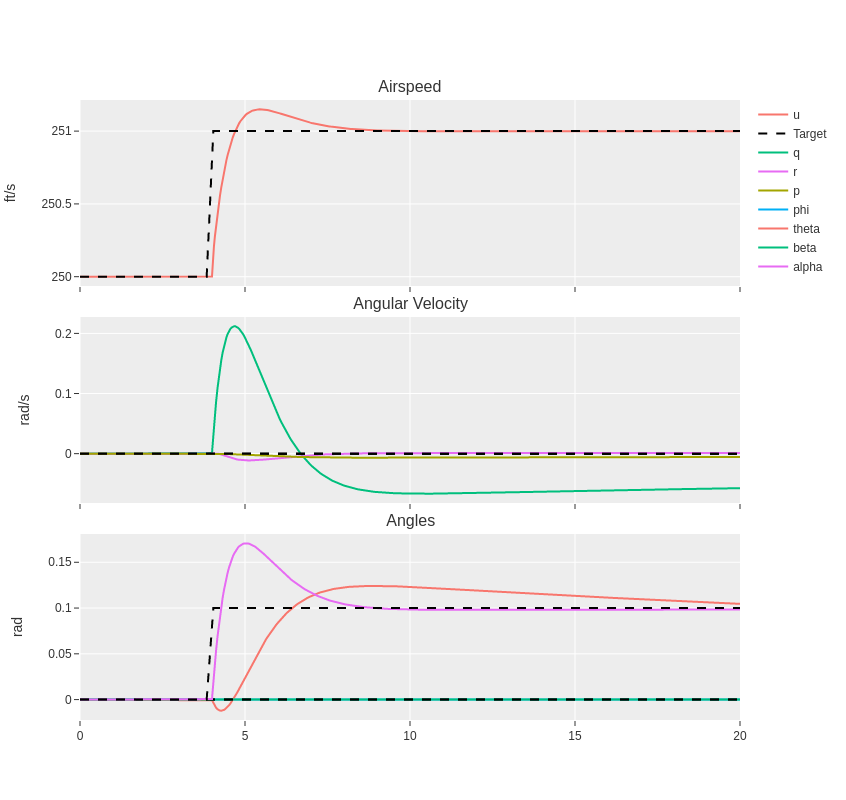

In [12]:
p.plot(res.t, res.y[1:], [[0 for _t in res.t] for i in range(4)], flat=True, target=(time_vect, target_pos), input_=False)

## Design an RSLQR to track a constant roll ($\phi$) command

In [13]:
target_pos = [np.array([250, 0, 0, 0, 0, 0, 0, 0])] * 20 +  [np.array([250, 0, 0, 0, 0, 0, 0, 0.2])] * 80
time_vect = np.linspace(0, 20, 100)

In [14]:
R = np.diag([1, 1, 1, 1]) * 100
Q = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1]) * 10

In [15]:
p = Plane()

In [16]:
res = p.simulate_controlled(time_vector=time_vect, target_states=target_pos, Q=Q, R=R, control_index=(7, ))

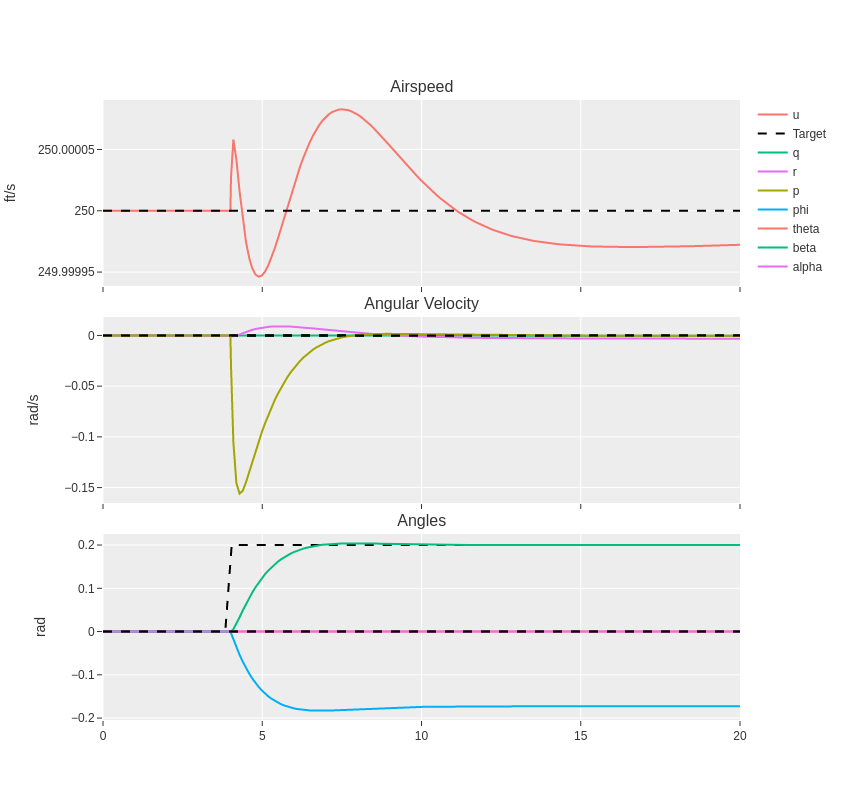

In [17]:
p.plot(res.t, res.y[1:], [[0 for _t in res.t] for i in range(4)], flat=True, target=(time_vect, target_pos), input_=False)

In [18]:
# [[_y[ind][0] for _y in y] for ind in range(8)]